In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from e3smplot.e3smplot import plot_utils
import json

import Ngl
import Nio

In [2]:
ds = xr.open_dataset('/global/project/projectdirs/m3312/crjones/E3SM_TEST-CRM-WIND_GPU_ne30pg2_FSP1V1_00/E3SM_TEST-CRM-WIND_GPU_ne30pg2_FSP1V1_00.cam.h1.0001-01-01-00000.nc')
scrip_file = '/global/cscratch1/sd/crjones/maml/maps_e3sm/ne30pg2_scrip.nc'
ds_grid = xr.open_dataset(scrip_file).rename(grid_size='ncol').load()

In [3]:
# prep data:
# ignore time=0 since it's all zeros
prect = ds['PRECT'].isel(time=slice(1, len(ds.time))).mean(dim='time')

## Approach:
1. Identify nodes with persistent high precip ("corner nodes mostly").
2. Look at profiles compared to neighboring cells.
3. Plot composites, see what they do.

In [4]:
def persist_to_file(file_name):
    """Cache results of function evaluation to file_name."""
    def decorator(original_func):
        try:
            cache = json.load(open(file_name, 'r'))
        except (IOError, ValueError):
            cache = {}

        def new_func(param):
            if param not in cache:
                cache[param] = original_func(param)
                json.dump(cache, open(file_name, 'w'))
            return {int(key): val for key, val in cache[param].items()}
        return new_func

    return decorator

In [5]:
@persist_to_file('cache_e3sm_neighborhoods.dat')
def identify_neighbors_faster(scrip_file):
    """Return dictionary of form {ncol ind: list of neighboring indices} based on scrip file
    
    Neighbors determined by sharing sides based on grid_corner_lon, grid_corner_lat
    """
    ds_grid = xr.open_dataset(scrip_file).rename(grid_size='ncol').load()
    cx = ds_grid.grid_corner_lon
    cy = ds_grid.grid_corner_lat
    
    # Update pts with to account for periodicity
    pts = np.stack((cx, cy), axis=-1)  # [ncol, 4, 2]
    pts[pts == 360] = 0  # lon 360 = lon 0
    pts[np.nonzero(pts[:, :, -1] == 90)] = [0, 90]  # long. meaningless at poles
    pts[np.nonzero(pts[:, :, -1] == -90)] = [0, -90]
    pts = np.around(pts, decimals=4)  # round to avoid round-off errors in equality testing
    npts, ncorners = pts.shape[0:2]
    neighbors = {n: [] for n in range(npts)}
    for n in range(npts):
        if n % 1000 == 0:
            print('made it to ', n)
        # only look to points we haven't checked yet
        # candidates share corner points with pts[n]
        candidates = np.concatenate([np.nonzero((pts[n][i] == pts[(n+1):]).all(axis=-1))[0] for i in range(ncorners)])

        # neighbors share exactly 2 corner points with pts[n]
        these_neighbors = [int(n + 1 + ind) for ind, count in zip(*np.unique(candidates, return_counts=True)) if count == 2]
        neighbors[n].extend(these_neighbors)

        # also need to update newly found neighbors to include `n` in their list of neighbors
        for ind in these_neighbors:
            neighbors[ind].append(n)
        # should have exactly 4 neighbors for each point in pg2 -- if not, investigate
        if len(neighbors[n]) != 4:
            print('something wacky going on')
            print(n, neighbors[n])
            print(candidates)
    return neighbors

In [6]:
%%time
neighbors = identify_neighbors_faster(scrip_file)

CPU times: user 5.04 ms, sys: 332 µs, total: 5.37 ms
Wall time: 5.27 ms


## now that neighbors have been identified, we can continue ...

In [7]:
def select_region(ds, region, lat=None, lon=None, drop=False):
    """ Returns ds subset to region"""
    lat_min, lat_max = region['lat']
    lon_min, lon_max = region['lon']
    if lat is None:
        lat = ds.lat
    if lon is None:
        lon = ds.lon
    return ds.where((lat > lat_min) & (lat < lat_max) & (lon > lon_min) & (lon < lon_max), drop=drop)

In [8]:
# focus on this region here: [140, 180, -15, 15]
region = {'lat': (-15, 15), 'lon': (140, 180)}
# ds_reg = select_region(ds, region)

In [9]:
def bias_relative_to_neighbors(arr, neighbors, axis=0):
    """Bias of arr values relative to neighbors
    
    inputs: 
    arr: numpy array of values to calculate local biases for
    neighbors: dictionary such that neighbors[ind] returns a list of indices corresponding to the 
               neighbors of arr[ind]
    axis defines the "ncol" axis in arr
    
    output: array with same shape as arr corresponding to arr[ind] - mean(arr[neighbors[ind]])
    """
    # Easiest to work with this when ncol axis is first
    arr_loc = arr.swapaxes(0, axis)
    dat_out = np.empty_like(arr_loc)
    print(arr.shape, arr_loc.shape, dat_out.shape)  # sanity check
    for ind, neighbor_inds in neighbors.items():
        dat_out[ind] = arr_loc[ind] - arr_loc[neighbor_inds].mean(axis=0)
    # swap back to original and output dat_out
    return dat_out.swapaxes(0, axis)

In [10]:
def is_checkered(arr, neighbors, axis=1):
    """Determine if 'bias-relative-to-neighbors' array has checkerboard pattern
    
    input:
    arr: numpy array of local bias relative to neighbors
    neighbors: dictionary such that neighbors[ind] returns a list of indices corresponding to the
               neighbors of arr[ind]
    axis: the `time` axis of arr. If no time axis, use axis=0
    
    returns:
    logical array with with 1 anywhere arr has opposite sign to all 4 neighbors, 0 otherwise
    """
    # Easiest to work with this when time axis is first
    arr_loc = arr.swapaxes(0, axis)
    dat_out = np.empty_like(arr_loc)
    arr_sign = np.sign(arr_loc)
    for ind, neighbor_inds in neighbors.items():
        dat_out[ind] = np.all(arr_sign[ind] != arr_sign[neighbor_inds], axis=0)
    return dat_out.swapaxes(0, axis)

In [11]:
def dict_to_resource(**kwargs):
    """ convert dictionary (key, val) pairs to Ngl resources"""
    res = Ngl.Resources()
    for key, val in kwargs.items():
        setattr(res, key, val)
    return res

In [12]:
def ngl_map_plot(dat, file_name='tmp_plot', **kwargs):
    """create NCL-style plot of map from dat and save in file_name"""
    #-open a workstation
    wkres = Ngl.Resources()
    wks_type = "png"
    wks = Ngl.open_wks(wks_type, file_name, wkres)

    #-- set resources (default)
    res = Ngl.Resources()
    res.cnFillMode = "CellFill"    # set fill mode

    #-- define region
    lat_min = -45
    lat_max = 45
    lon_min = -180
    lon_max = 180

    # Lat/lon arrays of curvilinear grid for overlaying on map 
    res.sfXArray = ds.lon.values
    res.sfYArray = ds.lat.values
    res.sfXCellBounds  = ds_grid.grid_corner_lon.values
    res.sfYCellBounds  = ds_grid.grid_corner_lat.values

    # -- Select region
    res.mpLimitMode = "LatLon"
    res.mpMinLatF = lat_min
    res.mpMinLonF = lon_min
    res.mpMaxLatF = lat_max 
    res.mpMaxLonF = lon_max
    res.cnFillOn = True
    res.cnLinesOn = False
    res.cnLineLabelsOn = False
    res.cnInfoLabelOn = False

    # -- draw the contour map
    res.tiMainString = "PRECT"
    res.lbOrientation = "Horizontal"
    res.lbLabelFontHeightF = 0.008
    
    # update additional options from kwargs:
    for key, val in kwargs.items():
        setattr(res, key, val)

    # -- create the contour plot
    plot = Ngl.contour_map(wks, dat, res)

In [13]:
# checkered biz:
dprec_tot_bias = bias_relative_to_neighbors(ds['PRECT'].values[1:, :], neighbors, axis=1)
checkered = is_checkered(dprec_tot_bias.mean(axis=0), neighbors, axis=0)
checkered.shape
# dprec_tot_bias.mean(axis=0).shape
# checkered = is_checkered(dprec_tot_bias.mean(axis=0))
# dat_out = bias_relative_to_neighbors(arr, neighbors, axis=1)

(7, 21600) (21600, 7) (21600, 7)


(21600,)

In [63]:
ngl_map_plot(checkered, "tmp_plot_checkered", cnFillPalette="BlWhRe",
             mpMinLatF=-60, mpMaxLatF=60,
             cnLevelSelectionMode="ExplicitLevels",
             cnLevels=np.arange(0, 2, 1),
             tiMainString='opposite sign to all neighbors')

![title](tmp_plot_checkered.png)

# Next up, need to select on these
* step 1: apply "tracking" approach, and avoid any that aren't at least size _n_ (say 4) or more. 

In [14]:
from e3sm_analysis_and_plots.e3sm_utils import e3sm_neighborhoods

In [15]:
ds = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/E3SM_TEST-CRM-WIND_GPU_ne30pg2_FSP1V1_00/E3SM_TEST-CRM-WIND_GPU_ne30pg2_FSP1V1_00.cam.h1.*.nc',
                       combine='by_coords')
ds

<xarray.Dataset>
Dimensions:       (crm_nx: 64, crm_ny: 1, crm_nz: 58, ilev: 73, lev: 72, nbnd: 2, ncol: 21600, time: 41)
Coordinates:
  * lev           (lev) float64 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * ilev          (ilev) float64 0.1 0.1477 0.218 0.3219 ... 990.5 997.0 1e+03
  * time          (time) object 0001-01-01 00:00:00 ... 0001-01-06 00:00:00
Dimensions without coordinates: crm_nx, crm_ny, crm_nz, nbnd, ncol
Data variables:
    lat           (time, ncol) float64 dask.array<chunksize=(8, 21600), meta=np.ndarray>
    lon           (time, ncol) float64 dask.array<chunksize=(8, 21600), meta=np.ndarray>
    area_p        (time, ncol) float64 dask.array<chunksize=(8, 21600), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(8, 72), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(8, 72), meta=np.ndarray>
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    hyai          (time, ilev) float64 dask.array<chunksize=(8, 73), meta=np.ndarray>
    hybi          (time, ilev) float64 dask.array<chunksize=(8, 73), meta=np.ndarray>
    date          (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    datesec       (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(8, 2), meta=np.ndarray>
    date_written  (time) |S8 dask.array<chunksize=(8,), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(8,), meta=np.ndarray>
    ndbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nbdate        (time) int32 10101 10101 10101 10101 ... 10101 10101 10101
    nbsec         (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mdt           (time) int32 1200 1200 1200 1200 1200 ... 1200 1200 1200 1200
    ndcur         (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    nscur         (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    n2ovmr        (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(8,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(8,), meta=np.ndarray>
    CLDICE        (time, lev, ncol) float32 dask.array<chunksize=(8, 72, 21600), meta=np.ndarray>
    CLDLIQ        (time, lev, ncol) float32 dask.array<chunksize=(8, 72, 21600), meta=np.ndarray>
    CLOUD         (time, lev, ncol) float32 dask.array<chunksize=(8, 72, 21600), meta=np.ndarray>
    CRM_QC        (time, crm_nz, crm_ny, crm_nx, ncol) float32 dask.array<chunksize=(8, 58, 1, 64, 21600), meta=np.ndarray>
    CRM_QI        (time, crm_nz, crm_ny, crm_nx, ncol) float32 dask.array<chunksize=(8, 58, 1, 64, 21600), meta=np.ndarray>
    CRM_QV        (time, crm_nz, crm_ny, crm_nx, ncol) float32 dask.array<chunksize=(8, 58, 1, 64, 21600), meta=np.ndarray>
    CRM_T         (time, crm_nz, crm_ny, crm_nx, ncol) float32 dask.array<chunksize=(8, 58, 1, 64, 21600), meta=np.ndarray>
    CRM_U         (time, crm_nz, crm_ny, crm_nx, ncol) float32 dask.array<chunksize=(8, 58, 1, 64, 21600), meta=np.ndarray>
    CRM_V         (time, crm_nz, crm_ny, crm_nx, ncol) float32 dask.array<chunksize=(8, 58, 1, 64, 21600), meta=np.ndarray>
    CRM_W         (time, crm_nz, crm_ny, crm_nx, ncol) float32 dask.array<chunksize=(8, 58, 1, 64, 21600), meta=np.ndarray>
    FLNT          (time, ncol) float32 dask.array<chunksize=(8, 21600), meta=np.ndarray>
    FSNT          (time, ncol) float32 dask.array<chunksize=(8, 21600), meta=np.ndarray>
    LHFLX         (time, ncol) float32 dask.array<chunksi

In [16]:
# checkered biz:
dprec_tot_bias = bias_relative_to_neighbors(ds['PRECT'].values[1:, :], neighbors, axis=1)
checkered = is_checkered(dprec_tot_bias.mean(axis=0), neighbors, axis=0)  # mean should find stationary values?
checkered.shape

(40, 21600) (21600, 40) (21600, 40)


(21600,)

## Begin tracking these patterns now

In [17]:
prect = ds['PRECT'].values[1:, :]
prect

array([[1.2570399e-08, 1.3004695e-09, 2.5769197e-08, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.2187497e-09, 2.1619359e-08, 7.4061495e-09, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.8513961e-09, 1.4088919e-08, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 4.7601978e-11, ..., 0.0000000e+00,
        6.5860371e-13, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 8.7642648e-14, ..., 1.4115509e-11,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 4.2898237e-13, ..., 5.0169946e-10,
        2.4742427e-14, 0.0000000e+00]], dtype=float32)

In [18]:
prect_bias = bias_relative_to_neighbors(prect, neighbors, axis=1)

(40, 21600) (21600, 40) (21600, 40)


In [19]:
# whoa, it actually works!!
checkered = is_checkered(prect_bias, neighbors, axis=1)

In [20]:
# validated
checkered_test = is_checkered(prect_bias[7, :], neighbors, axis=0)
np.all(checkered[7] == checkered_test)

True

In [21]:
CF = e3sm_neighborhoods.ConnectedFeature(neighbors=neighbors, unlabeled_mask=checkered)

In [22]:
CF.do_it_all()  # label connected features and stitch together in time

In [23]:
CF.calculate_extent()

In [24]:
CF.labeled_feature.shape

(40, 21600)

In [25]:
CF.calculate_lifetimes()

(array([5.7074e+04, 1.3675e+04, 6.7330e+03, 3.9980e+03, 2.7070e+03,
        2.0020e+03, 0.0000e+00, 1.4260e+03, 9.7100e+02, 8.7400e+02,
        6.1300e+02, 4.5300e+02, 3.7300e+02, 0.0000e+00, 3.6000e+02,
        3.3300e+02, 3.2100e+02, 2.3400e+02, 1.8500e+02, 1.0000e+02,
        0.0000e+00, 2.2000e+01, 2.5000e+01, 2.5000e+01, 2.7000e+01,
        1.5000e+01, 2.0000e+01, 0.0000e+00, 7.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 1.        ,  1.85714286,  2.71428571,  3.57142857,  4.42857143,
         5.28571429,  6.14285714,  7.        ,  7.85714286,  8.71428571,
         9.57142857, 10.42857143, 11.28571429, 12.14285714, 13.        ,
        13.85714286, 14.71428571, 15.57142857, 16.42857143, 17.28571429,
        18.14285714, 19.        , 19.85714286, 20.71428571, 21.57142857,
        22.42857143, 23.28571429, 24.14285714, 25.        , 25.85714286,
        26.71428571, 27.57142857, 28.42857143, 29.28571429, 30.14285714,
        31.

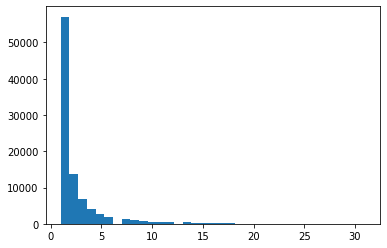

In [26]:
plt.hist(np.array([v for v in CF._lifetimes.values()]), bins=35)

(array([6.152e+03, 2.260e+03, 1.920e+03, 1.185e+03, 1.165e+03, 6.840e+02,
        7.940e+02, 4.450e+02, 3.170e+02, 4.140e+02, 5.890e+02, 4.110e+02,
        1.580e+02, 2.090e+02, 2.130e+02, 1.650e+02, 1.910e+02, 0.000e+00,
        0.000e+00, 1.680e+02, 2.610e+02, 0.000e+00, 1.711e+03, 3.500e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.450e+02, 2.200e+01]),
 array([  5.        ,   8.14285714,  11.28571429,  14.42857143,
         17.57142857,  20.71428571,  23.85714286,  27.        ,
         30.14285714,  33.28571429,  36.42857143,  39.57142857,
         42.71428571,  45.85714286,  49.        ,  52.14285714,
         55.28571429,  58.42857143,  61.57142857,  64.71428571,
         67.85714286,  71.        ,  74.14285714,  77.28571429,
         80.42857143,  83.57142857,  86.71428571,  89.85714286,
         93.        ,  96.14285714,  99.28571429, 102.42857143,
        105.57142857, 108.71428571, 111.85714286, 115

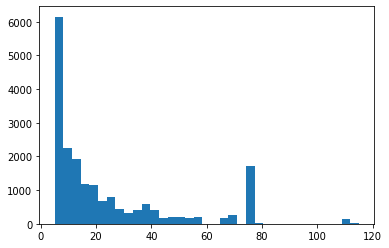

In [27]:
plt.hist(np.array([v for v in CF._max_extent.values() if v > 4]), bins=35)

In [28]:
the_keys = [k for k in CF._lifetimes.keys()]
lifetimes = np.array([CF._lifetimes[k] for k in the_keys])
extents = np.array([CF._max_extent[k] for k in the_keys])

## Collect some statistics

In [42]:
checkers = CF.labeled_feature.copy()
checkers.shape

(40, 21600)

In [43]:
# select on larger than 3:
for key, extent in CF._max_extent.items():
    if extent < 4:
        checkers[checkers == key] = 0

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


In [56]:
lwp = ds['TGCLDLWP'].values[1:, :]

In [58]:
mask = checkers > 0

In [ ]:
lwp_checkered = np.ma.array(lwp, mask=mask)

In [64]:
((lwp * mask).sum(axis=0) / mask.sum(axis=0)).shape

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(21600,)

In [47]:
checkers.shape

(40, 21600)

In [52]:
time_fraction_checkered = np.count_nonzero(checkers, axis=0) / checkers.shape[0]

In [53]:
ngl_map_plot(time_fraction_checkered, "time_frac_checkered",
             mpMinLatF=-60, mpMaxLatF=60,
             cnLevelSelectionMode="ExplicitLevels",
             cnLevels=np.arange(0, 1.1, 0.1),
             tiMainString='fraction of time each pixel is checkered')

![title](time_frac_checkered.png)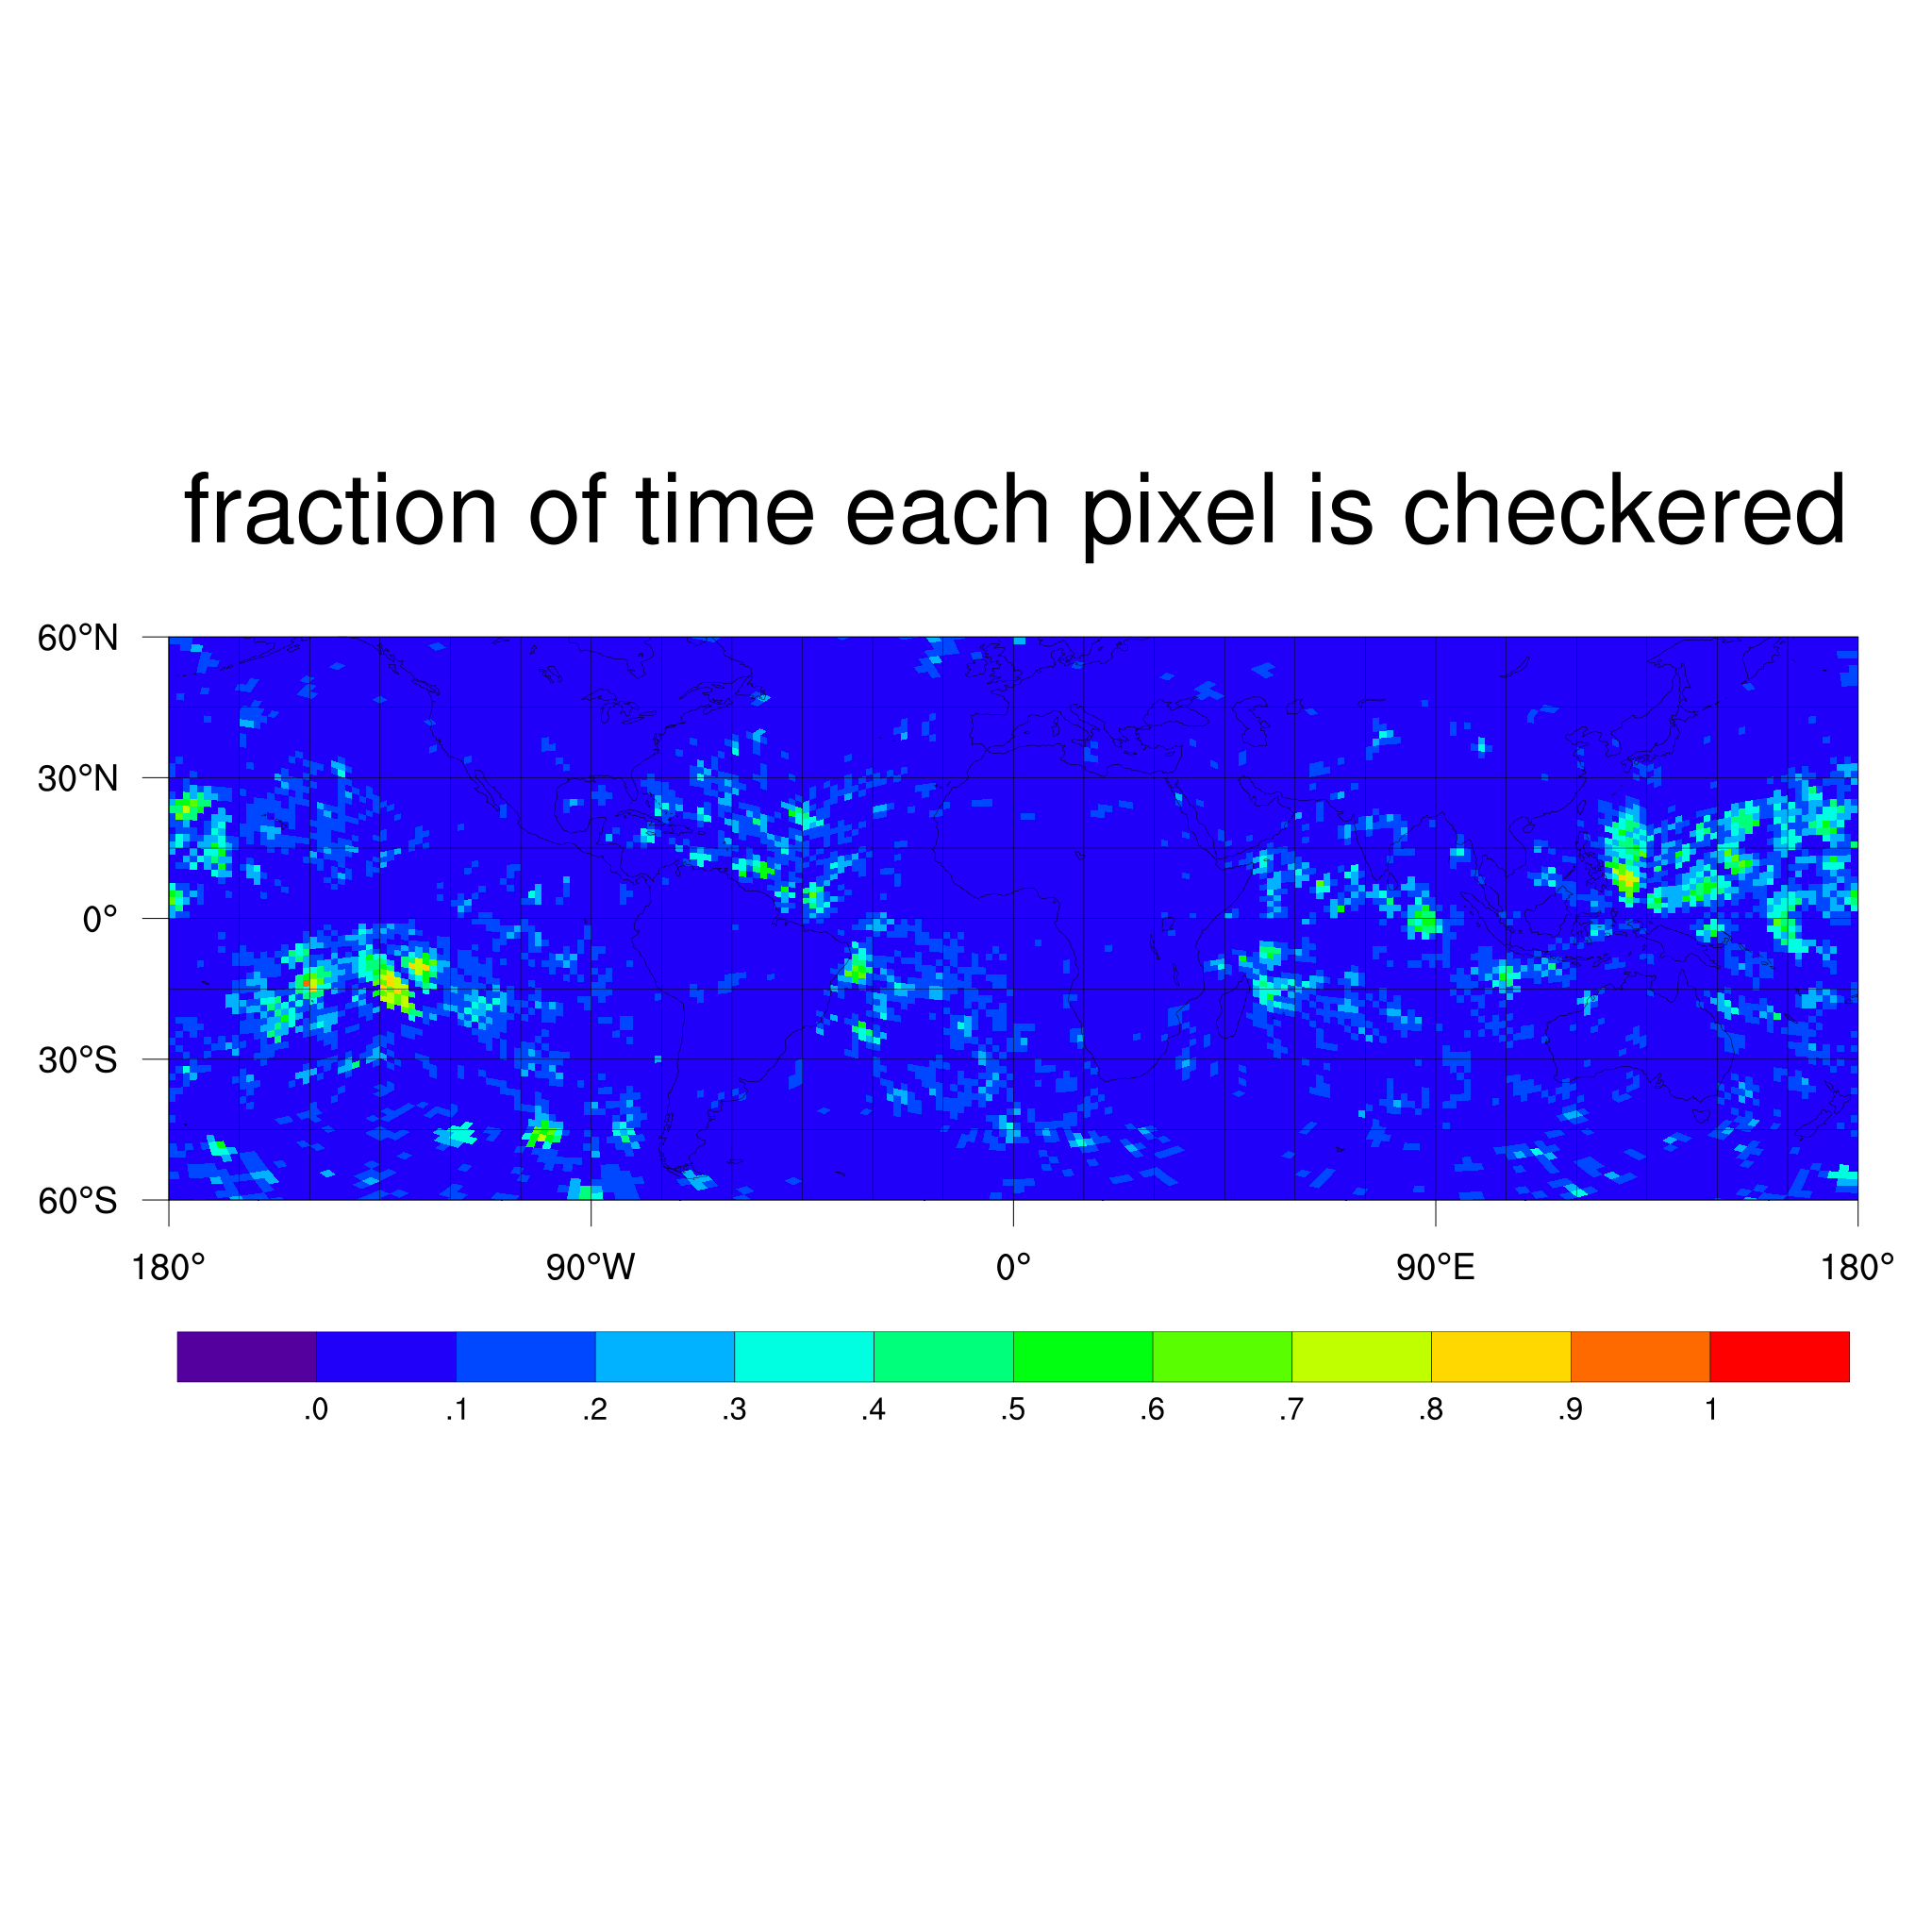

In [46]:
checkers[checkers == 20]

array([20, 20, 20, 20, 20, 20, 20])

In [40]:
CF._max_extent

{1: 1,
 2: 2,
 3: 1,
 4: 1,
 5: 2,
 6: 2,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 7,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 2,
 29: 2,
 30: 1,
 31: 1,
 32: 1,
 33: 2,
 34: 1,
 35: 5,
 36: 1,
 37: 1,
 38: 2,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 3,
 45: 2,
 46: 4,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 2,
 55: 1,
 56: 2,
 57: 1,
 58: 1,
 59: 4,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 2,
 66: 4,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 3,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 2,
 79: 1,
 80: 5,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 8,
 88: 1,
 89: 6,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 5,
 96: 1,
 97: 2,
 98: 1,
 99: 1,
 100: 1,
 101: 3,
 102: 1,
 103: 1,
 104: 1,
 105: 2,
 106: 3,
 107: 1,
 108: 3,
 109: 4,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 119: 1,
 120: 2,
 121: 4,
 122: 1,
 123: 3,
 

(array([0.000e+00, 3.391e+03, 2.911e+03, 2.171e+03, 2.635e+03, 1.212e+03,
        1.017e+03, 1.288e+03, 9.230e+02, 6.270e+02, 7.100e+02, 6.970e+02,
        6.590e+02, 5.640e+02, 4.660e+02, 3.330e+02, 3.860e+02, 5.490e+02,
        3.040e+02, 3.120e+02, 2.410e+02, 1.240e+02, 3.190e+02, 1.570e+02,
        2.260e+02, 4.110e+02, 2.260e+02, 5.600e+01, 4.700e+01, 1.160e+02,
        1.910e+02, 5.900e+01, 6.700e+01, 1.100e+01, 1.570e+02, 2.460e+02,
        0.000e+00, 1.520e+02, 4.370e+02, 0.000e+00, 7.100e+01, 3.400e+02,
        1.900e+01, 1.300e+01, 1.260e+02, 1.990e+02, 8.000e+00, 2.000e+00,
        1.400e+02, 4.300e+01, 3.000e+01, 0.000e+00, 4.100e+01, 1.230e+02,
        1.000e+00, 0.000e+00, 0.000e+00, 1.910e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+01, 0.000e+00,
        1.480e+02, 2.610e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.711e+03, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.500e+01, 0.000e+0

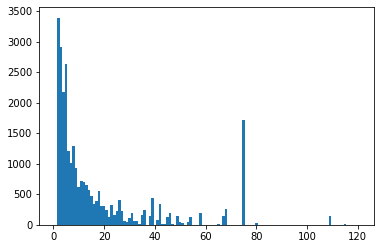

In [39]:
plt.hist(extents[extents>1], bins=np.arange(0.5, 121.5))

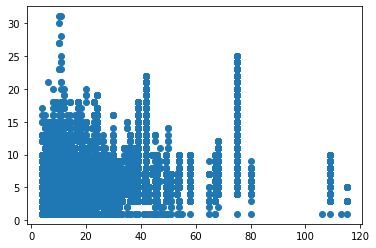

In [69]:
plt.scatter(extents[extents > 3], lifetimes[extents > 3])

In [33]:
the_labeled_features = CF.labeled_feature

In [34]:
the_labeled_features.shape

(40, 21600)

In [47]:
extent_threshold = 9
large_clusters = {pt: extent for pt, extent in CF._max_extent.items()
                  if extent >= extent_threshold and not isinstance(pt, tuple)}
print(*[(k, v) for k, v in large_clusters.items()], sep='\n')

(238, 9)
(347, 10)
(407, 10)
(408, 11)
(417, 11)
(474, 12)
(507, 10)
(523, 10)
(530, 9)
(635, 13)
(636, 13)
(829, 13)
(845, 11)
(865, 13)
(1037, 12)
(1076, 9)
(1176, 22)
(1216, 15)
(1228, 11)
(1258, 9)
(1327, 9)
(1330, 19)
(1344, 13)
(1366, 12)
(1465, 9)
(1504, 9)
(1537, 17)
(1640, 11)
(1741, 18)
(1773, 14)
(1831, 9)
(1998, 20)
(2084, 25)
(2087, 11)
(2094, 12)
(2110, 9)
(2148, 9)
(2158, 12)
(2243, 10)
(2277, 15)
(2279, 9)
(2354, 10)
(2485, 12)
(2736, 13)
(2758, 12)
(2783, 9)
(2895, 16)
(2905, 10)
(3040, 12)
(3086, 17)
(3101, 15)
(3125, 9)
(3155, 12)
(3237, 13)
(3325, 9)
(3464, 13)
(3484, 14)
(3514, 9)
(3531, 21)
(3640, 19)
(3664, 9)
(3749, 14)
(3758, 9)
(3775, 13)
(3880, 14)
(3899, 9)
(3921, 17)
(3951, 14)
(3987, 11)
(3993, 19)
(4020, 14)
(4036, 13)
(4046, 9)
(4082, 13)
(4115, 23)
(4145, 22)
(4151, 13)
(4166, 20)
(4178, 12)
(4211, 10)
(4399, 9)
(4413, 11)
(4423, 9)
(4448, 9)
(4469, 18)
(4472, 18)
(4493, 17)
(4506, 9)
(4520, 9)
(4567, 12)
(4716, 11)
(4746, 9)
(4758, 11)
(4820, 12)
(4900

In [69]:
ngl_map_plot(checkered, "plot_checkered_fiveday", cnFillPalette="BlWhRe",
             mpMinLatF=-60, mpMaxLatF=60,
             cnLevelSelectionMode="ExplicitLevels",
             cnLevels=np.arange(0, 2, 1),
             tiMainString='opposite sign to all neighbors')

![title](plot_checkered_fiveday.png)

Comparing the above 5-day mean figure to the 1-day mean suggests that the "checkered" regions actually expand in the 5-day mean compared to the 1 day mean. Does that seem right?

In [74]:
ngl_map_plot(dprec_tot_bias.mean(axis=0), "plot_prectbias_fiveday",
             mpMinLatF=-60, mpMaxLatF=60,
             tiMainString='PRECT bias relative to neighbors - 5 day')

![title](plot_prectbias_fiveday.png)

In [ ]:
checkered = is_checkered(dprec_tot_bias, neighbors, axis=0)  # mean should find stationary values?

In [86]:
# focus only on large clusters
checkered_large = np.zeros_like(CF.unlabeled_feature)
for key in large_clusters.keys():
    checkered_large[CF.labeled_feature == key] = 1

In [97]:
checkered_large.shape

(1, 21600)

In [89]:
# sanity check
np.count_nonzero(checkered_large) == sum(large_clusters.values())

True

In [91]:
CF_large = e3sm_neighborhoods.ConnectedFeature(neighbors, unlabeled_mask=checkered_large)
CF_large.do_it_all()

In [98]:
# large clusters only:
ngl_map_plot(checkered_large[0, :], "plot_checkered_large_fiveday", cnFillPalette="BlWhRe",
             mpMinLatF=-60, mpMaxLatF=60,
             cnLevelSelectionMode="ExplicitLevels",
             cnLevels=np.arange(0, 2, 1),
             tiMainString='clusters 9 or larger')

![title](plot_checkered_large_fiveday.png)

In [100]:
# what if i try to track these dudes?
checkered_in_time = is_checkered(dprec_tot_bias, neighbors, axis=1)  # mean should find stationary values?

In [103]:
CF_in_time = e3sm_neighborhoods.ConnectedFeature(neighbors, unlabeled_mask=checkered_in_time)
CF_in_time.do_it_all()

(array([763763.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 100237.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

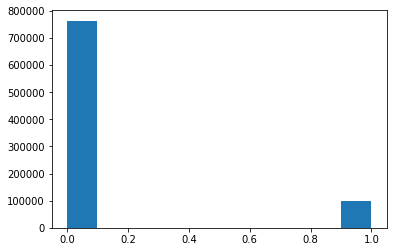

In [102]:
plt.hist(checkered_in_time.flatten())

In [99]:
checkered.shape

(21600,)

In [76]:
np.unique(CF.labeled_feature)

array([   0,    1,    2, ..., 1202, 1203, 1204])

In [80]:
checkered.shape

(21600,)

In [77]:
large_clusters

{3: 5,
 4: 6,
 6: 12,
 10: 5,
 15: 7,
 19: 15,
 23: 7,
 28: 17,
 45: 6,
 56: 14,
 58: 4,
 62: 5,
 63: 4,
 74: 29,
 78: 5,
 82: 15,
 83: 13,
 117: 10,
 118: 5,
 130: 6,
 131: 59,
 152: 7,
 154: 7,
 172: 14,
 175: 16,
 177: 4,
 195: 5,
 217: 5,
 239: 5,
 242: 47,
 249: 10,
 250: 13,
 259: 14,
 264: 4,
 265: 12,
 268: 16,
 269: 6,
 276: 45,
 279: 6,
 285: 4,
 291: 4,
 297: 6,
 300: 4,
 305: 12,
 306: 9,
 308: 77,
 311: 8,
 313: 5,
 314: 4,
 315: 4,
 318: 8,
 326: 61,
 330: 6,
 333: 11,
 339: 5,
 340: 4,
 345: 11,
 369: 5,
 370: 4,
 424: 4,
 430: 5,
 443: 15,
 448: 7,
 460: 4,
 469: 63,
 471: 8,
 476: 13,
 483: 6,
 492: 5,
 493: 47,
 506: 4,
 515: 27,
 521: 47,
 533: 6,
 536: 8,
 546: 60,
 547: 37,
 551: 4,
 559: 8,
 561: 22,
 562: 15,
 566: 4,
 570: 4,
 574: 67,
 578: 6,
 581: 4,
 583: 10,
 586: 4,
 589: 6,
 598: 27,
 600: 10,
 601: 5,
 612: 12,
 634: 4,
 645: 5,
 648: 4,
 666: 14,
 674: 6,
 675: 8,
 686: 7,
 695: 6,
 700: 23,
 706: 54,
 711: 4,
 720: 12,
 723: 31,
 731: 5,
 740: 5,
 751:

# Zooming in on a tighter region
Using the region posted on Confluence 10-16S, 127-134W.

In [94]:
ngl_map_plot(dprec_rel, "tmp_plot8", cnFillPalette="BlWhRe",
             mpMinLatF=-16, mpMaxLatF=-10,
             mpMinLonF=360-134, mpMaxLonF=360-127,
             tiMainString='delta prect (relative)')

![image](tmp_plot8.png)

In [99]:
ngl_map_plot(ds['PRECT'].isel(time=slice(1, 8)).mean(dim='time'), 
             "tmp_plot9",
             mpMinLatF=-16, mpMaxLatF=-10,
             mpMinLonF=360-134, mpMaxLonF=360-127,
             cnLevelSelectionMode="ExplicitLevels",
             cnLevels=[1.e-9, 2.e-9, 4.e-9, 1.e-8, 2.e-8, 4.e-8, 1.e-7, 2.e-7, 4.e-7, 1.e-6],
             tiMainString='PRECT')

![image](tmp_plot9.png)

In [101]:
ngl_map_plot(ds['TGCLDLWP'].isel(time=slice(1, 8)).mean(dim='time'), 
             "tmp_plot10",
             mpMinLatF=-16, mpMaxLatF=-10,
             mpMinLonF=360-134, mpMaxLonF=360-127,
             cnLevelSelectionMode="ExplicitLevels",
             cnLevels=np.arange(0, 0.1, 0.01),
             tiMainString='LWP')

![title](tmp_plot10.png)

In [105]:
ngl_map_plot(ds['TMQ'].isel(time=slice(1, 8)).mean(dim='time'), 
             "tmp_plot_tmq",
             mpMinLatF=-16, mpMaxLatF=-10,
             mpMinLonF=360-134, mpMaxLonF=360-127,
             cnLevelSelectionMode="ExplicitLevels",
             cnLevels=np.arange(20, 40, 2),
             tiMainString='TMQ')

![title](tmp_plot_tmq.png)

region = {'lat': (-16, -10), 'lon': (-134 + 360, -127 + 360)}

In [89]:
def sel_region(ds, region):
    lats = ds.lat
    lons = ds.lon
    lat_box = (lats > region['lat'][0]) & (lats < region['lat'][-1])
    lon_box = (lons > region['lon'][0]) & (lons < region['lon'][-1])
    mask = lat_box & lon_box
    return ds.where(mask, drop=True), mask

In [90]:
ds_reg, mask = sel_region(ds, region)

In [92]:
ds_reg

<xarray.Dataset>
Dimensions:       (crm_nx: 64, crm_ny: 1, crm_nz: 58, ilev: 73, lev: 72, nbnd: 2, ncol: 20, time: 8)
Coordinates:
  * lev           (lev) float64 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * ilev          (ilev) float64 0.1 0.1477 0.218 0.3219 ... 990.5 997.0 1e+03
  * time          (time) object 0001-01-01 00:00:00 ... 0001-01-01 21:00:00
Dimensions without coordinates: crm_nx, crm_ny, crm_nz, nbnd, ncol
Data variables:
    lat           (ncol) float64 -15.16 -14.0 -15.51 ... -11.05 -11.28 -10.08
    lon           (ncol) float64 227.2 227.2 228.7 230.2 ... 230.2 231.7 231.7
    area_p        (ncol) float64 0.0005129 0.0005155 ... 0.0005387 0.0005409
    hyam          (lev, ncol) float64 0.0001238 0.0001238 0.0001238 ... 0.0 0.0
    hybm          (lev, ncol) float64 0.0 0.0 0.0 0.0 ... 0.9985 0.9985 0.9985
    P0            (ncol) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    hyai          (ilev, ncol) float64 0.0001 0.0001 0.0001 ... 0.0 0.0 0.0
    hybi

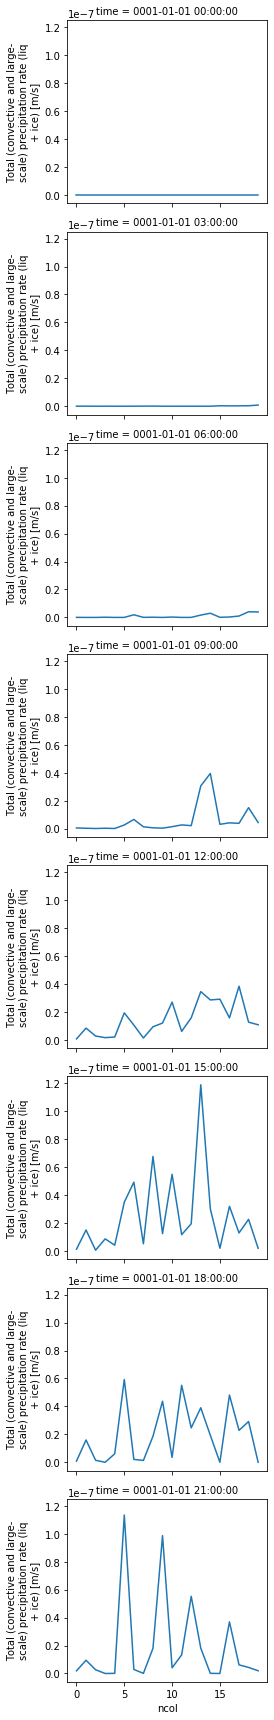

In [93]:
ds_reg['PRECT'].plot(row='time', col=)

In [ ]:
ngl_map_plot(dprec_a, "tmp_plot4", cnFillPalette="BlWhRe",
             cnLevelSelectionMode="ExplicitLevels",
             cnLevels=[-4e-7, -3e-7, -2e-7, -1e-7, -5e-8, 5e-8, 1e-7, 2e-7, 3e-7, 4e-7],
             mpMinLatF=-60, mpMaxLatF=60)

![title](tmp_plot4.png)

In [254]:
def bias_relative_to_neighbors_3d(da, neighbors, ind):
    da_neighbors = da.isel(ncol=neighbors[ind]).mean(dim='ncol').squeeze()
    da_self = da.isel(ncol=ind).squeeze()
    delta = da_self - da_neighbors
    return delta, da_self, da_neighbors

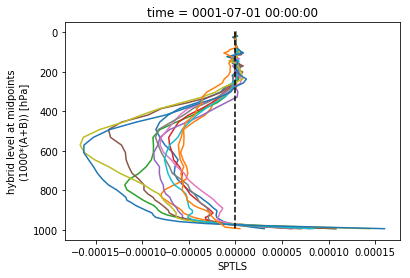

In [261]:
for ncol in ncols:
    delta1, _, _ = bias_relative_to_neighbors_3d(ds_dat['SPTLS'], neighbors, ncol)
    delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
plt.plot([0, 0], [0, 1000], 'k--')

In [247]:
delta1

<xarray.DataArray 'SPQTLS' (lev: 72)>
array([-5.428533e-08, -5.428533e-08, -5.428533e-08, -5.428533e-08,
       -5.428533e-08, -5.428533e-08, -5.428533e-08, -5.428533e-08,
       -5.428533e-08, -5.428533e-08, -5.428533e-08, -5.428533e-08,
       -5.428533e-08, -5.428533e-08, -5.428533e-08, -5.428530e-08,
       -5.428531e-08, -5.428521e-08, -5.428641e-08, -5.431180e-08,
       -5.438614e-08, -5.465218e-08, -5.547878e-08, -5.561190e-08,
       -5.281481e-08, -5.311664e-08, -5.434402e-08, -5.539250e-08,
       -5.259802e-08, -5.181771e-08, -5.073824e-08, -4.853735e-08,
       -4.620972e-08, -4.277492e-08, -3.777760e-08, -3.021416e-08,
       -1.960519e-08, -6.590959e-09,  7.844147e-09,  2.238835e-08,
        3.436491e-08,  3.806382e-08,  3.314653e-08,  3.238949e-08,
        3.084304e-08,  2.660680e-08,  3.096268e-08,  3.384562e-08,
        2.928391e-08,  1.753947e-08,  1.222082e-08,  5.732613e-09,
        1.094044e-08,  1.262550e-08,  1.206950e-08,  1.553825e-08,
        1.261892e-08,  1

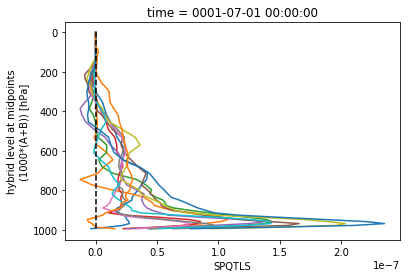

In [262]:
for ncol in ncols:
    delta1, da1, _ = bias_relative_to_neighbors_3d(ds_dat['SPQTLS'], neighbors, ncol)
    # delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
    delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
plt.plot([0, 0], [0, 1000], 'k--')

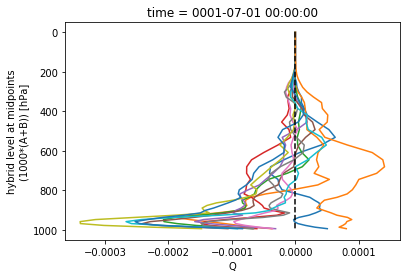

In [263]:
for ncol in ncols:
    delta1, da1, _ = bias_relative_to_neighbors_3d(ds_dat['Q'], neighbors, ncol)
    # delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
    delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
plt.plot([0, 0], [0, 1000], 'k--')

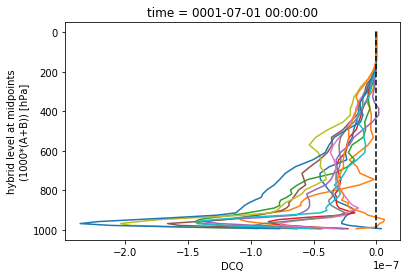

In [269]:
for ncol in ncols:
    delta1, da1, _ = bias_relative_to_neighbors_3d(ds_dat['DCQ'], neighbors, ncol)
    # delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
    delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
plt.plot([0, 0], [0, 1000], 'k--')

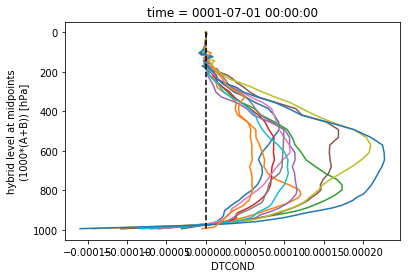

In [270]:
for ncol in ncols:
    delta1, da1, _ = bias_relative_to_neighbors_3d(ds_dat['DTCOND'], neighbors, ncol)
    # delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
    delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
plt.plot([0, 0], [0, 1000], 'k--')

In [271]:
ds_dat['DTCOND'].attrs

OrderedDict([('mdims', 6),
             ('units', 'K/s'),
             ('long_name', 'T tendency - moist processes'),
             ('cell_methods', 'time: mean')])

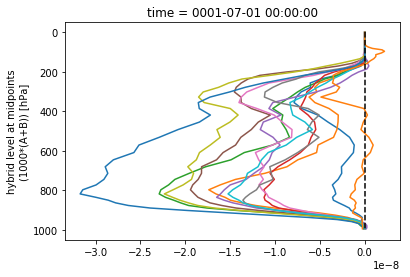

In [268]:
for ncol in ncols:
    delta1, da1, _ = bias_relative_to_neighbors_3d(ds_dat['DCQ'] + ds_dat['SPQTLS'], neighbors, ncol)
    # delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
    delta1.isel(lev=slice(None, -1)).plot(y='lev', yincrease=False)
plt.plot([0, 0], [0, 1000], 'k--')

In [267]:
ds_dat['DCQ'].attrs

OrderedDict([('mdims', 6),
             ('units', 'kg/kg/s'),
             ('long_name', 'Q tendency due to moist processes'),
             ('cell_methods', 'time: mean')])

In [276]:
for v in atts_dict.keys():
    print(v)
    print(atts_dict[v])
    print('\n')

lat
OrderedDict([('long_name', 'latitude'), ('units', 'degrees_north')])


lon
OrderedDict([('long_name', 'longitude'), ('units', 'degrees_east')])


area
OrderedDict([('long_name', 'gll grid areas')])


hyam
OrderedDict([('long_name', 'hybrid A coefficient at layer midpoints')])


hybm
OrderedDict([('long_name', 'hybrid B coefficient at layer midpoints')])


P0
OrderedDict([('long_name', 'reference pressure'), ('units', 'Pa')])


hyai
OrderedDict([('long_name', 'hybrid A coefficient at layer interfaces')])


hybi
OrderedDict([('long_name', 'hybrid B coefficient at layer interfaces')])


date
OrderedDict([('long_name', 'current date (YYYYMMDD)')])


datesec
OrderedDict([('long_name', 'current seconds of current date')])


time_bnds
OrderedDict([('long_name', 'time interval endpoints')])


date_written
OrderedDict()


time_written
OrderedDict()


ndbase
OrderedDict([('long_name', 'base day')])


nsbase
OrderedDict([('long_name', 'seconds of base day')])


nbdate
OrderedDict([('long_name

In [273]:
atts_dict = {v: ds_dat[v].attrs for v in ds_dat}

In [195]:
da = ds_reg.PRECC.squeeze()
da

<xarray.DataArray 'PRECC' (ncol: 48602)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    time     object 0001-07-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    units:         m/s
    long_name:     Convective precipitation rate (liq + ice)
    cell_methods:  time: mean

(array([643., 440., 135.,  66.,  19.,   7.,   5.,   1.,   1.,   3.]),
 array([1.2647935e-11, 6.3683991e-08, 1.2735534e-07, 1.9102669e-07,
        2.5469802e-07, 3.1836939e-07, 3.8204072e-07, 4.4571206e-07,
        5.0938343e-07, 5.7305476e-07, 6.3672610e-07], dtype=float32),
 <a list of 10 Patch objects>)

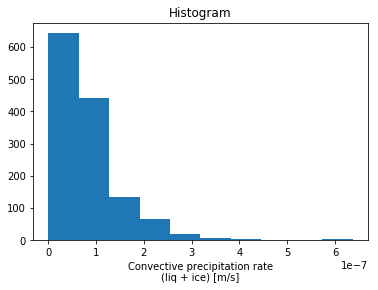

In [201]:
ds_reg.PRECC.squeeze().plot.hist()

In [198]:
da[mask].values = bias_relative_to_neighbors(ds_dat.PRECC.values.squeeze(), neighbors, mask=mask)

(array([643., 440., 135.,  66.,  19.,   7.,   5.,   1.,   1.,   3.]),
 array([1.2647935e-11, 6.3683991e-08, 1.2735534e-07, 1.9102669e-07,
        2.5469802e-07, 3.1836939e-07, 3.8204072e-07, 4.4571206e-07,
        5.0938343e-07, 5.7305476e-07, 6.3672610e-07], dtype=float32),
 <a list of 10 Patch objects>)

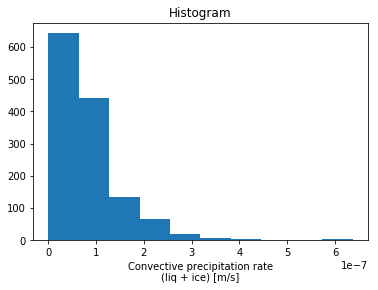

In [200]:
da[mask].plot.hist()

In [194]:
dat_out

array([ 8.6747143e-10, -5.9358727e-09,  1.3667407e-08, ...,
       -1.7705080e-08, -2.9335766e-08,  6.5972444e-08], dtype=float32)

In [176]:
np.count_nonzero(np.isnan(dat_out))

154

## Extras
Verify that "neighbors calculation is reasonable.

0 [1, 4, 5, 25010, 25012, 40506]
50 [46, 47, 48, 49, 51, 394, 395, 396]
273 [269, 270, 272, 275, 276, 280, 283, 286]
10903 [10893, 10896, 10899, 10900, 10901, 10904, 10906, 10907]
48307 [48297, 48300, 48304, 48305, 48308, 48516, 48520, 48521]


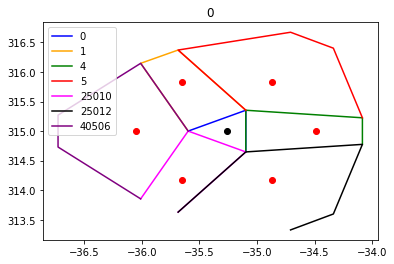

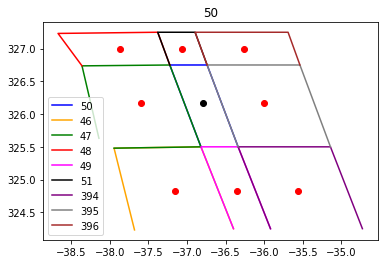

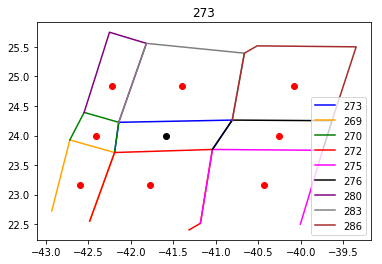

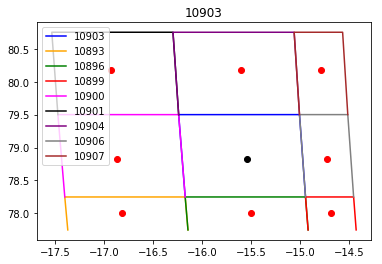

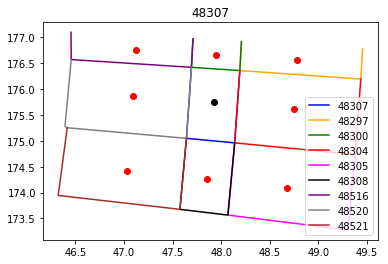

In [53]:
cols = ['b', 'orange', 'green', 'red', 'magenta', 'black', 'purple', 'gray', 'brown']
# visual inspection of a few random elements to make sure this isn't completely whack
for i1 in [0, 50, 273, 10903, 48307]:
    plt.figure()
    i2 = neighbors[i1]
    print(i1, i2)
    pts = {v: list(zip(ds_map.sel(grid_size=v).grid_corner_lat.values, ds_map.sel(grid_size=v).grid_corner_lon.values)) for v in [i1, *i2]}
    for cc, i in enumerate(pts.keys()):
        plt.plot(*zip(*pts[i]), label=i, color=cols[cc])
    plt.legend()
    for i in pts.keys():
        center = (ds_map.sel(grid_size=i).grid_center_lat.values, ds_map.sel(grid_size=i).grid_center_lon.values)
        if i == i1:
            plt.plot(*center, 'ko')
        else:
            plt.plot(*center, 'ro')
    plt.title(i1)

In [20]:
ds_map = xr.open_dataset(ds_neighbors)
ds_map

<xarray.Dataset>
Dimensions:          (grid_corners: 5, grid_rank: 1, grid_size: 48602)
Dimensions without coordinates: grid_corners, grid_rank, grid_size
Data variables:
    grid_area        (grid_size) float64 ...
    grid_center_lat  (grid_size) float64 ...
    grid_center_lon  (grid_size) float64 ...
    grid_corner_lon  (grid_size, grid_corners) float64 ...
    grid_corner_lat  (grid_size, grid_corners) float64 ...
    grid_imask       (grid_size) float64 ...
    grid_dims        (grid_rank) int32 ...
Attributes:
    title:       ne30np4
    Created_by:  HOMME2SCRIP.ncl mt 2009
    history:     HOMME2SCRIP.ncl mt 2009

In [24]:
pts = {v: list(zip(ds_map.sel(grid_size=v).grid_corner_lat.values, ds_map.sel(grid_size=v).grid_corner_lon.values)) for v in [i1, *i2]}
pts

{0: [(-35.597721370794055, 315.0),
  (-35.597721370794055, 315.0),
  (-35.09721138169065, 315.35282543749344),
  (-35.09721138169297, 314.64717456250196),
  (-35.09721138169297, 314.64717456250196)],
 1: [(-35.597721370794055, 315.0),
  (-36.010060679014686, 316.1474317116835),
  (-35.68494824101157, 316.37221169296424),
  (-35.09721138169065, 315.35282543749344),
  (-35.09721138169065, 315.35282543749344)],
 4: [(-35.09721138169297, 314.64717456250196),
  (-35.09721138169065, 315.35282543749344),
  (-34.08481934629346, 315.2249957733118),
  (-34.084819346292356, 314.7750042266935),
  (-34.084819346292356, 314.7750042266935)],
 5: [(-35.09721138169065, 315.35282543749344),
  (-35.68494824101157, 316.37221169296424),
  (-34.70864025412336, 316.673448015001),
  (-34.33702618928869, 316.403715311581),
  (-34.08481934629346, 315.2249957733118)],
 25010: [(-36.01006067901113, 313.8525682883194),
  (-35.597721370794055, 315.0),
  (-35.09721138169297, 314.64717456250196),
  (-35.6849482410249

In [32]:
print(*pts[0], sep='\n')
print('\n')
print(*pts[40506], sep='\n')

(-35.597721370794055, 315.0)
(-35.597721370794055, 315.0)
(-35.09721138169065, 315.35282543749344)
(-35.09721138169297, 314.64717456250196)
(-35.09721138169297, 314.64717456250196)


(-36.01006067901113, 313.8525682883194)
(-36.72752262319537, 314.72988081868965)
(-36.727522623195505, 315.2701191813086)
(-36.010060679014686, 316.1474317116835)
(-35.597721370794055, 315.0)


In [33]:
pts0 = pts[0]
pts_ids = {val: [pts0.index(item) for item in pts[val] if item in pts0] for val in i2}
pts_ids

{1: [0, 2, 2], 4: [3, 2], 5: [2], 25010: [0, 3], 25012: [3], 40506: [0]}

In [34]:
pts[0]

[(-35.597721370794055, 315.0),
 (-35.597721370794055, 315.0),
 (-35.09721138169065, 315.35282543749344),
 (-35.09721138169297, 314.64717456250196),
 (-35.09721138169297, 314.64717456250196)]

In [35]:
pts[1] # note duplicate entries (maybe start and finish of pentagon? That seems unexpected, though ...)

[(-35.597721370794055, 315.0),
 (-36.010060679014686, 316.1474317116835),
 (-35.68494824101157, 316.37221169296424),
 (-35.09721138169065, 315.35282543749344),
 (-35.09721138169065, 315.35282543749344)]

In [36]:
pts[4]

[(-35.09721138169297, 314.64717456250196),
 (-35.09721138169065, 315.35282543749344),
 (-34.08481934629346, 315.2249957733118),
 (-34.084819346292356, 314.7750042266935),
 (-34.084819346292356, 314.7750042266935)]

## Using Ben's plotting routines
Still need some work to make this approach work for me ...

In [21]:
variable_name = 'PRECT'
data = ds[variable_name].isel(time=3)
xv = ds_grid['grid_corner_lon'].rename({'grid_size': 'ncol'})
yv = ds_grid['grid_corner_lat'].rename({'grid_size': 'ncol'})

lon = ds['lon']
lat = ds['lat']

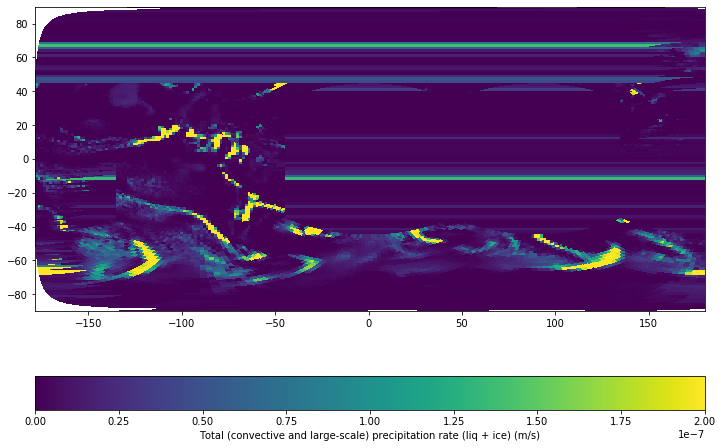

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
p = plot_utils.plot_unstructured(xv, yv, data, antialiased=False)
p.set_clim([0, 2e-7])
cb = plt.colorbar(p, orientation='horizontal', label='%s (%s)'%(data.long_name, data.units))

In [9]:
# slower but clearer version. Validated it works the same, but no reason to use it. 
def identify_neighbors(cx, cy):
    pts = np.stack((cx, cy), axis=-1)  # [ncol, 4, 2]
    # replace all 360 with 0 in lon
    pts[pts == 360] = 0
    # +/- 90 lat points are all equal, too.
    pts[np.nonzero(pts[:, :, -1] == 90)] = [0, 90]
    pts[np.nonzero(pts[:, :, -1] == -90)] = [0, -90]
    npts = pts.shape[0]
    pts = np.around(pts, decimals=4)
    neighbors = {}
    for n in range(npts):
        if n % 100 == 0:
            print('made it to ', n)
        candidates = np.concatenate([np.nonzero((pts[n][i] == pts).all(axis=-1))[0] for i in range(4)])
        neighbors[n] = [ind for ind, count in zip(*np.unique(candidates, return_counts=True)) if count == 2]
        if len(neighbors[n]) != 4:
            print('something wacky going on')
            print(n, neighbors[n])
            print(candidates)
    return neighbors